In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
import json
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from __future__ import print_function
import numpy as np
import cv2
from model import swin_base_patch4_window7_224_in22k as create_model

/root/anaconda3/envs/py38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def main():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    fig = plt.figure(figsize=(6, 6))
    img_size = 224
    #224
    #true_answer = [0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1]
    #128
    true_answer = [0,0,0,0,0,1,0,0,0,0, #0
                   0,0,0,0,0,0,0,0,0,0,#1
                   0,1,0,1,0,0,0,0,0,0,#2
                   0,0,0,0,0,0,0,0,0,0,#3
                   1,1,0,0,1,0,0,0,0,1,#4
                   0,0,0,0,1,0,0,0,0,0,#5
                   0,0,0,0,0,0,0,0,1,0,#6
                   0,0,1,1,0,0,0,0,1,0,#7
                   0,0,0,0,0,0,0,0,1,0,#8
                   1,0,0,0,0,1,0,0,0,0,#9
                   0,0,0,0,0,1,1,1,0,1,#10
                   0,0,0,0,0,0,0,0,0,0,#11
                   0,1,0,0,0,1,1,0,0,0,#12
                   1,0,1,0,0,0,0,0,1,1,#13
                   0,0,0,0,0,1,1,0,0,0,#14
                   0,0,0,0,0,0,0,0,0,0,#15
                   0,0,0,0,1,0,1,0,0,0,#16
                   0,0,0,0,0,0,0,0,0,0,#17
                   0,0,0,0,0,1,1,0,1,1,#18
                   0,0,0,0,1,1,0,0,1,1,#19
                   1,0,0,0,0,0,0,1,0,0,#20
                   1,0,0,0,0,0,0,0,1,0,#21
                   0,0,0,0,0,0,0,0,1,0,#22
                   0,0,0,1,0,0,0,0,0,0,#23
                   0,0,0,0,0,0,0,0,0,1,#24
                   0,0,0,1,0,1,0,0,1,0,#25
                   0,0,0,0,1,1,0,0,0,0,#26
                   0,0,0,0,0,0,0,0,0,0,#27
                   0,0,1,1,0,1,1,0,1,0,#28
                   0,1,0,0,0,0,0,0,0,0,#29
                   0,0,1,0,0,0,0,0,0,0,#30
                   0,0,1,0,0,0,0,1,1,0,#31
                   0,0,0,0,1,1,0,1,0,0,#32
                   0,0,0,0,0,1,0,0,0,0,#33
                   0,0,0,0,0,0,0,0,0,0,#34
                   0,0,0,1,1,0,0,0,1,1,#35
                   0,1,0,0,1,0,0,0,0,0,#36
                   0,1,0,0,0,0,0,1,0,1,#37
                   0,0,0,1,0,0,0,0,0,0,#38
                   0,0,0,1,0,0,0,0,1,0,#39
                   1,0,0,0,0,0,0,0,0,0,#40
                   1,1,1,0,0,0,0,1,0,0,#41
                   0,0,0,0,0,0,1,0,1,0,#42
                   1,0,0,0,0,0,0,0,0,0,#43
                   1,0,0,0,0,0,1,0,0,0,#44
                   0,0,0,0,0,0,0,0,0,0,#45
                   0,0,0,0,0,0,1,0,0,0,#46
                   0,0,0,0,0,0]
    num_list = len(true_answer)
    test = []
    number = 0  #总个数
    in_num = 0  #预测为损毁
    no_num = 0
    num = 0  #预测错误的个数
    data_transform = transforms.Compose(
        [transforms.Resize(int(img_size * 1.143)),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    # load image
    img_path = "../EAST_128_256.png"
    assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
    img = Image.open(img_path)
    img_true = Image.open(img_path)
    [X_Width, Y_Hieght] = img.size
    x_cut = X_Width % 256
    y_cut = Y_Hieght % 256
    # [N, C, H, W]array(array)
    #img = data_transform(img)
    # expand batch dimension
    #img = torch.unsqueeze(img, dim=0)

    # read class_indict
    json_path = './class_indices.json'
    assert os.path.exists(json_path), "file: '{}' dose not exist.".format(json_path)

    json_file = open(json_path, "r")
    class_indict = json.load(json_file)
    
    # create model
    model = create_model(num_classes=2 , input_size=[1024, 7, 7], routings=3)
    if torch.cuda.device_count() > 1:
        print("Use", torch.cuda.device_count(), 'gpus')
        model = nn.DataParallel(model, device_ids=[0])
    #model = model.to(device)
    # load model weights
    #model = torch.nn.DataParallel(model, device_ids=[1])
    model_weight_path = "./weights/last_model.pth"
    model.load_state_dict(torch.load(model_weight_path, map_location=device),False)
    model.eval()
    dx = 255
    dy = 255
    n = 1 
    FN = 0    #预测结果为0，预测错了
    FP = 0    #预测结果为1，预测错了
    TN = 0    #预测结果为0，预测对了
    TP = 0    #预测结果为1，预测对了
    

    # 左上角切割
    x1 = 0
    y1 = 0
    x2 = dx
    y2 = dy
    flag1 = 0
    flag2 = 0
    # 纵向
    while (x2 <= Y_Hieght) and (flag1 < 1):
        # 横向切
        while (y2 <= X_Width) and (flag2 < 1):
            #print(true_answer[number])
            #number = number + 1
            # print n,x1,y1,x2,y2
            img2 = img.crop((y1, x1, y2, x2))
#             img2.show()
#             print(n)
#             img2.show()
            img3 = img2.copy()
            img4 = img2.copy()
            img2 = data_transform(img2)
            # expand batch dimension
            img2 = torch.unsqueeze(img2, dim=0)
            # expand batch dimension
            
            with torch.no_grad():
                #print(model(img2.to(device)))
                #pred_classes = torch.max(labels1_pred, dim=1)[1]
                output  = torch.squeeze(model(img2.to(device))[0]).cpu()
                predict = torch.softmax(output, dim=0)
                predict_cla = torch.argmax(predict).numpy()
            #遍历每一个像素块，并处理颜色
#             print('预测结果:',class_indict[str(predict_cla)])
#             print('真实结果:',true_answer[number])
            img3 = np.array(img3)     #用于透明覆盖
            img4 = np.array(img4)     #底层图片
            
            if class_indict[str(predict_cla)] == "in_destroy":   #有损伤1
                #img4 = Image.fromarray(img4, 'RGB')
                if true_answer[number] == 0:#预测有损伤 真实无损伤
                    FP = FP +1
                    cv2.rectangle(img3, (0, 0), (256, 256),(0, 255, 0), -1)   #画一个矩形方块    绿色
                    cv2.addWeighted(img3, 0.4, img4, 0.6,0, img4)
                else:#预测有损伤 真实有损伤
                    TP = TP + 1
                    cv2.rectangle(img3, (0, 0), (256, 256),(255, 48, 48), -1)   #画一个矩形方块    红色
                    cv2.addWeighted(img3, 0.4, img4, 0.6,0, img4)
                    plt.imshow(img4)
                in_num = in_num + 1
                test.append(1)
                for y in range(y1,y2):
                    for x in range(x1,x2):
                        #print(y)
                        #print(x)
                        R = img4[x-x1][y-y1][0]
                        G = img4[x-x1][y-y1][1]
                        B = img4[x-x1][y-y1][2]
                        img.putpixel((y,x),(R,G,B))
            else:   #没有损伤0
                #img4 = Image.fromarray(img4, 'RGB')
                if true_answer[number] == 0:#预测没有损伤，真实没有损伤
                    TN = TN + 1
                    cv2.rectangle(img3, (0, 0), (256, 256),(0, 0, 255), -1)   #画一个矩形方块    蓝色
                    cv2.addWeighted(img3, 0.4, img4, 0.6,0, img4)
                else:#预测没有损伤，真实有损伤
                    FN = FN + 1
                    cv2.rectangle(img3, (0, 0), (256, 256),(255, 140, 0), -1)   #画一个矩形方块    橘色
                    cv2.addWeighted(img3, 0.4, img4, 0.6,0, img4)
                no_num = no_num + 1
                test.append(0)
                for x in range(x1,x2):
                    for y in range(y1,y2):
                        R = img4[x-x1][y-y1][0]
                        G = img4[x-x1][y-y1][1]
                        B = img4[x-x1][y-y1][2]
                        img.putpixel((y,x),(R,G,B))
#             if true_answer[number] == 0:
#                 for x in range(x1,x1+dx):
#                     for y in range(y1,y1+dy):
#                         img_true.putpixel((y,x),(0,0,0))
#             else:
#                 for x in range(x1,x1+dx):
#                     for y in range(y1,y1+dy):
#                         img_true.putpixel((y,x),(255,255,255))
            y1 = y1 + dy + 1
            y2 = y1 + dy + 1
            if(y2 > X_Width):
                flag2 = flag2 + 1
            n = n + 1
            number = number + 1
        x1 = x1 + dx + 1
        x2 = x1 + dx + 1
        y1 = 0
        y2 = dy
        flag2 =0
        if(x2 > Y_Hieght):
            flag1= flag1 + 1
    #print_res = "class: {}   prob: {:.3}".format(class_indict[str(predict_cla)],
                                                # predict[predict_cla].numpy())
    for i in range(num_list):
        if true_answer[i] == test[i]:
            num = num + 1
#     plt.subplot(121)
    plt.imshow(img)
#     plt.subplot(122)
#     plt.imshow(img_true)
#     plt.show()
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    precision = (TP)/(TP+FP)
    recall = TP/(TP+FN)
    F = (2 * recall * precision)/(precision+recall)
    print('FN:',FN)
    print('FP:',FP)
    print('TN:',TN)
    print('TP:',TP)
    print('accuracy:',accuracy)
    print('precision:',precision)
    print('recall:',recall)
    print('F:',(TP)/(TP+FP))

Use 2 gpus
FN: 40
FP: 200
TN: 189
TP: 47
accuracy: 0.4957983193277311
precision: 0.1902834008097166
recall: 0.5402298850574713
F: 0.1902834008097166


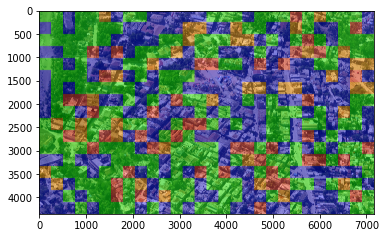

In [3]:
if __name__ == '__main__':
    main()